In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import requests
from sklearn.linear_model import LinearRegression


In [215]:
# Global Init Variables
GET_TEMPERATURES = False
GET_HUMIDITY = False


In [216]:
# read both observation files
true_observations_df = pd.read_json('../INaturalist_Scraper/Data/true_observations.json')
false_observations_df = pd.read_json('../INaturalist_Scraper/Data/false_observations.json')

# add powdery mildew bool feature for each collection
true_observations_df['PowderyMildew'] = True
false_observations_df['PowderyMildew'] = False

# concat collections
observations_df = pd.concat([true_observations_df, false_observations_df], ignore_index=True)

# Drop rows with missing values
observations_df = observations_df.dropna()

# remove date, we date_string is better
observations_df.drop('date', axis=1, inplace=True)

In [217]:
# Function to parse date string and extract components
def extract_date_components(date_string):
    import datetime
    # Parse ISO format date string
    dt = datetime.datetime.fromisoformat(date_string.replace('Z', '+00:00'))
    return dt.year, dt.month, dt.day

# Extract relevant data for true observations
lons = []
lats = []
years = []
months = []
days = []

for _, row in observations_df.iterrows():
    lons.append(row['coordinates'][0])
    lats.append(row['coordinates'][1])
    year, month, day = extract_date_components(row['date_string'])
    years.append(year)
    months.append(month)
    days.append(day)
    
observations_df['longitude'] = lons
observations_df['latitude'] = lats
observations_df['year'] = years
observations_df['month'] = months
observations_df['day'] = days

observations_df.sample(10)


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
1322,76515846,2021-05-02T13:22:02+02:00,"[13.1785783333, 52.4996616667]",False,13.178578,52.499662,2021,5,2
865,23590189,2019-04-28T10:47:00+12:00,"[172.6430143134, -43.7764175568]",False,172.643014,-43.776418,2019,4,28
771,169693368,2023-06-26T13:53:00-05:00,"[-87.9632867643, 41.7058173565]",False,-87.963287,41.705817,2023,6,26
644,131378351,2022-08-18T15:30:00+01:00,"[-2.8321547695, 53.4222684799]",False,-2.832155,53.422268,2022,8,18
1001,32522274,2019-09-11T08:36:51-04:00,"[-81.4360243266, 41.2446597318]",False,-81.436024,41.244660,2019,9,11
836,151779435,2023-03-18T16:26:00+13:00,"[172.604934, -43.559713]",False,172.604934,-43.559713,2023,3,18
522,42666805,2020-04-20T16:11:00+02:00,"[14.55713607, 50.03826317]",False,14.557136,50.038263,2020,4,20
197,253057259,2024-11-25T12:46:28+00:00,"[-0.3176127459, 53.8231353878]",False,-0.317613,53.823135,2024,11,25
434,113386429,2022-04-29T12:26:18+02:00,"[14.400059, 50.0747637778]",False,14.400059,50.074764,2022,4,29
1106,237644270,2024-08-24T16:47:36+03:00,"[37.4260965362, 55.7788715766]",False,37.426097,55.778872,2024,8,24


In [218]:
# Functions to fetch weather data
def get_temps(lon, lat, day, month, year):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)  # make sure is 2 length
    day_str = str(day).zfill(2)      # same as above
    start_date = int(f"{year}{month_str}{day_str}")
    
    parameters = {
        "parameters": "T2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": start_date,
        "format": "JSON"
    }

    response = requests.get(url, params=parameters)
    data = response.json()
    
    temperatures_total = 0
    try:
        for temperature in data['properties']['parameter']['T2M'].values():
            temperatures_total += (temperature * (9/5)) + 32  # convert to Fahrenheit
        temperature_avg = temperatures_total / 24
        return temperature_avg
    except:
        print(f"Error getting temperature data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None

def get_humidity(lon, lat, day, month, year):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)  # make sure is 2 length
    day_str = str(day).zfill(2)      # same as above
    start_date = int(f"{year}{month_str}{day_str}")
    
    parameters = {
        "parameters": "RH2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": start_date,
        "format": "JSON"
    }

    response = requests.get(url, params=parameters)
    data = response.json()
    
    humidity_total = 0
    try:
        for humidity in data['properties']['parameter']['RH2M'].values():
            humidity_total += humidity
        humidity_avg = humidity_total / 24
        return humidity_avg
    except:
        print(f"Error getting humidity data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None

In [219]:
# Add temperature data to dataframe and save 

if GET_TEMPERATURES:

    # Call get_temps for each row
    temperatures = []
    for i, row in observations_df.iterrows():
        temp = get_temps(row['longitude'], row['latitude'], row['day'], row['month'], row['year'])
        temperatures.append(temp)
        
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")

    # Add temps to dataframe
    observations_df['Temp'] = temperatures

    # Drop empty rows
    observations_df = observations_df.dropna(subset=['Temp'])

    # Save to CSV file
    observations_df.to_csv('observations_with_temps.csv', index=False)
    print(f"Saved processed dataframe with {len(observations_df)} observations to observations_with_temps.csv")
    
if GET_HUMIDITY:
    
        # Call get_temps for each row
    humidities = []
    for i, row in observations_df.iterrows():
        humidity = get_humidity(row['longitude'], row['latitude'], row['day'], row['month'], row['year'])
        humidities.append(humidity)
        
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")

    # Add temps to dataframe
    observations_df['Humidity'] = humidities

    # Drop empty rows
    observations_df = observations_df.dropna(subset=['Humidity'])

    # Save to CSV file
    observations_df.to_csv('observations_with_humidity.csv', index=False)
    print(f"Saved processed dataframe with {len(observations_df)} observations to observations_with_humidity.csv")


In [220]:
# Read in the both weather df
humidity_df = pd.read_csv('observations_with_humidity.csv')
temps_df = pd.read_csv('observations_with_temps.csv')

# add temp and humidity cols to total weather df
weather_df = pd.merge(humidity_df, temps_df[['id', 'Temp']], on='id', how='left')

weather_df.sample(10)

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Humidity,Temp
913,189476932,2023-10-30T15:12:24+01:00,"[16.340392828, 48.1660400241]",False,16.340393,48.166040,2023,10,30,83.720417,58.09775
796,98098961,2021-09-06T09:30:37-06:00,"[-105.2801366667, 40.189945]",False,-105.280137,40.189945,2021,9,6,19.388750,74.65925
441,209800320,2024-04-26T17:32:54+02:00,"[14.5061715692, 50.0038257994]",False,14.506172,50.003826,2024,4,26,68.668750,46.84475
1250,167586504,2023-05-27T12:00:55+01:00,"[-3.0630508053, 53.5124964119]",False,-3.063051,53.512496,2023,5,27,81.671250,57.75575
435,157757419,2023-04-29T16:52:00+02:00,"[14.5086066667, 50.0420516667]",False,14.508607,50.042052,2023,4,29,86.611250,51.83525
1134,160821136,2023-05-09T19:40:30+03:00,"[37.7360351756, 55.8231092542]",False,37.736035,55.823109,2023,5,9,62.449583,45.77975
310,85377201,2021-07-02T13:57:28-04:00,"[-79.8587822542, 43.3499159122]",False,-79.858782,43.349916,2021,7,2,71.084583,65.40050
949,52200717,2020-07-06T18:24:17-04:00,"[-72.5379996468, 42.423843476]",False,-72.538000,42.423843,2020,7,6,67.000833,74.63450
517,23109450,2019-04-26T10:38:13+02:00,"[14.3481815828, 50.1088710859]",False,14.348182,50.108871,2019,4,26,69.188750,60.64175
288,212574972,2024-05-01T15:44:37+03:00,"[27.5746399722, 53.952415]",False,27.574640,53.952415,2024,5,1,72.252917,59.96600


In [221]:
# convert target to bool
weather_df['PowderyMildew'] = weather_df['PowderyMildew'].astype(bool)

# Drop unnecessary columns
columns_to_drop = ['date_string', 'coordinates', 'id', 'year', 'latitude', 'longitude']
weather_df = weather_df.drop(columns=columns_to_drop)

In [222]:
y = weather_df['PowderyMildew']
X = weather_df.drop('PowderyMildew', axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Train the model on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8131313131313131


Feature Importances:
    Feature  Importance
2  Humidity    0.351601
3      Temp    0.347101
1       day    0.203058
0     month    0.098240


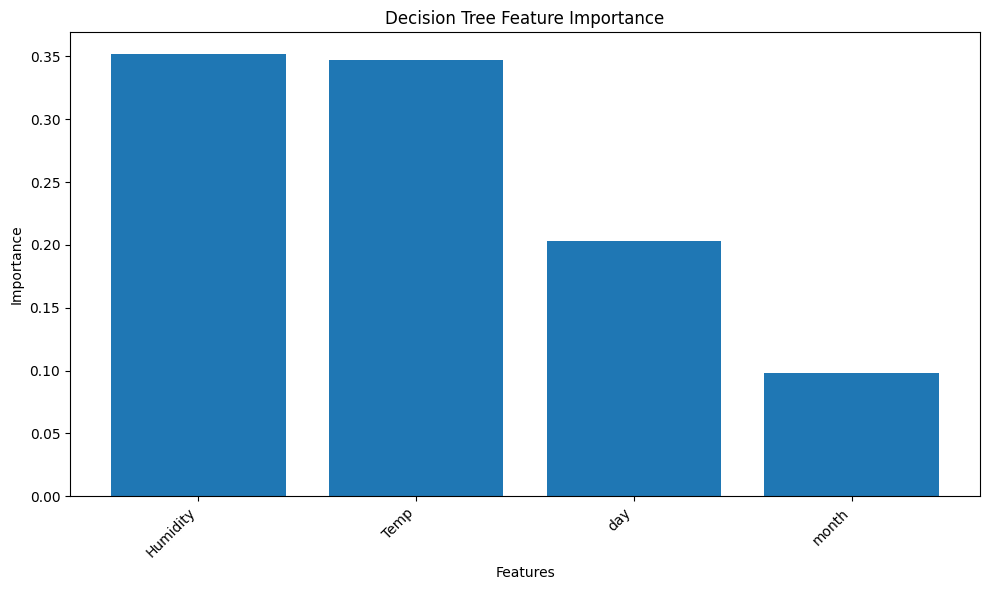

In [ ]:
# Get feature importances from the decision tree classifier
feature_importances = dt_classifier.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(importance_df)

# Visualize feature importances with a bar chart
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Get the probability estimates for the test set
y_prob = dt_classifier.predict_proba(X_test)

# Create a DataFrame to display the predictions and their confidence scores
confidence_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Confidence': np.max(y_prob, axis=1)  # Get the maximum probability (confidence)
})

# Add a column to indicate if the prediction was correct
confidence_df['Correct'] = confidence_df['Actual'] == confidence_df['Predicted']

# Display the confidence scores
print("Prediction Confidence Scores:")
print(confidence_df.head(10))  # Show first 10 rows

# Calculate average confidence for correct and incorrect predictions
avg_confidence_correct = confidence_df[confidence_df['Correct']]['Confidence'].mean()
avg_confidence_incorrect = confidence_df[~confidence_df['Correct']]['Confidence'].mean()

print(f"\nAverage confidence for correct predictions: {avg_confidence_correct:.4f}")
print(f"Average confidence for incorrect predictions: {avg_confidence_incorrect:.4f}")
